In [9]:
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn



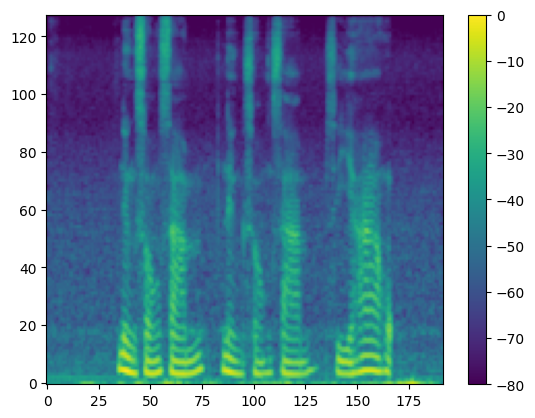

In [ ]:
def audio_to_melspectrogram(audio, sr=22050):
    if isinstance(audio, str):  # If input is a file path
        y, sr = librosa.load(audio, sr=sr)
    else:  # If input is a NumPy array (live audio)
        y = audio

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
    return mel_spec_db

# Example usage
mel_spectrogram = audio_to_melspectrogram(r"H:\DSP_project\ignoredir\data_test\Recording.wav")
plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
plt.colorbar()
plt.show()


In [37]:
data_df = pd.read_csv(r"H:\DSP_project\model\jupyter\God_data.csv", index_col=0)
data_df

,fname,Class,duration
0,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0
1,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0
2,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0
3,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0
4,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0
...,...,...,...
44620,H:\DSP_project\ignoredir\dataset\archive\music...,vibraphone,3.0
44621,H:\DSP_project\ignoredir\dataset\archive\music...,vibraphone,3.0
44622,H:\DSP_project\ignoredir\dataset\archive\music...,vibraphone,3.0
44623,H:\DSP_project\ignoredir\dataset\archive\music...,vibraphone,3.0


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [61]:
onehot = OneHotEncoder(sparse_output=False)
onehot.fit(data_df[["Class"]])

OneHotEncoder(sparse_output=False)

In [71]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, shuffle=True)

In [75]:
train_df

,fname,Class,duration
2264,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0
21075,H:\DSP_project\ignoredir\dataset\archive\music...,Electro_Guitar,3.0
27322,H:\DSP_project\ignoredir\dataset\archive\music...,Mandolin,3.0
3530,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0
41860,H:\DSP_project\ignoredir\dataset\archive\music...,flute,3.0
...,...,...,...
6265,H:\DSP_project\ignoredir\dataset\archive\music...,Acoustic_Guitar,3.0
11284,H:\DSP_project\ignoredir\dataset\archive\music...,Bass_Guitar,3.0
38158,H:\DSP_project\ignoredir\dataset\archive\music...,Ukulele,3.0
860,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.0


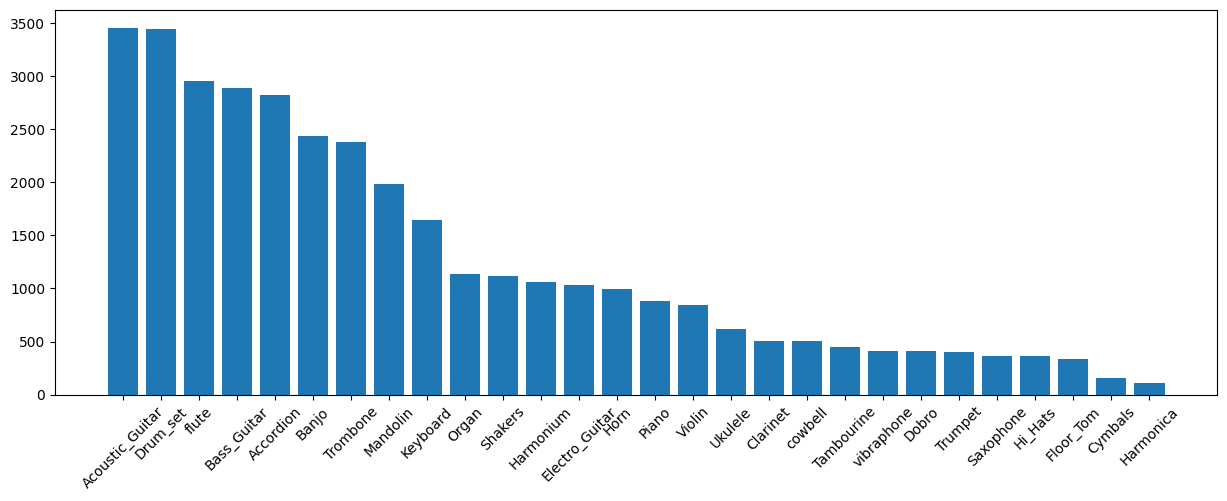

In [76]:
test = train_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

In [77]:
test_df

,fname,Class,duration
2791,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.000000
24065,H:\DSP_project\ignoredir\dataset\archive\music...,Horn,3.000000
3488,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.000000
3548,H:\DSP_project\ignoredir\dataset\archive\music...,Accordion,3.000000
31830,H:\DSP_project\ignoredir\dataset\archive\music...,Piano,3.000000
...,...,...,...
43816,H:\DSP_project\ignoredir\dataset\archive\music...,flute,3.000000
16961,H:\DSP_project\ignoredir\dataset\archive2\Trai...,Drum_set,13.653333
35922,H:\DSP_project\ignoredir\dataset\archive\music...,Trombone,3.000000
31757,H:\DSP_project\ignoredir\dataset\archive\music...,Piano,3.000000


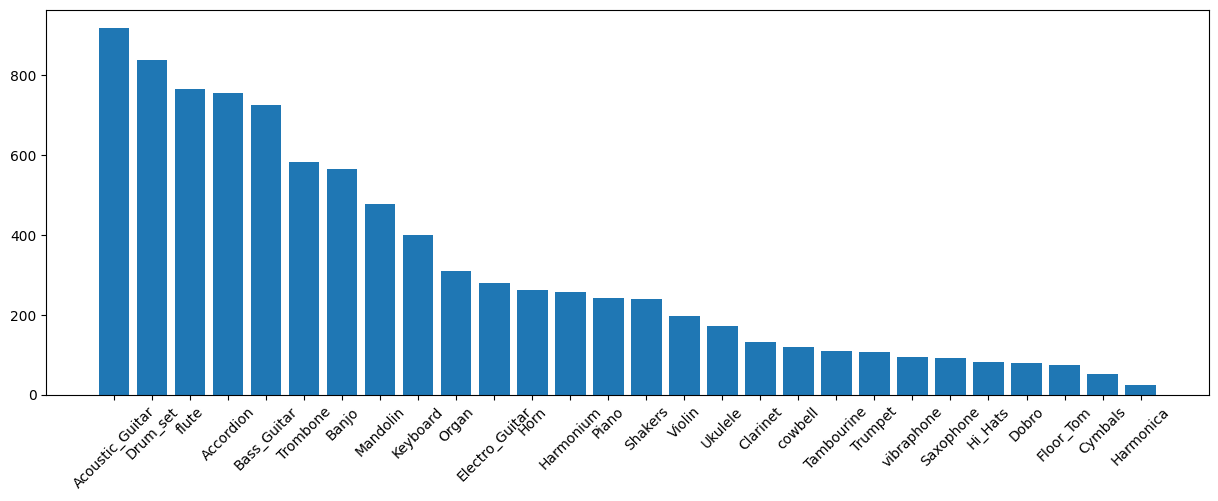

In [78]:
test = test_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

In [ ]:

class InstrumentDataset(Dataset):
    def __init__(self, dataframe, onehot, target_sr=44100, window_size=2.0, hop_size=1.0, n_mels=128):
        """
        dataframe: Pandas DataFrame containing 'filepath' and 'Class' columns.
        onehot: OneHotEncoder instance for encoding class labels.
        target_sr: Target sample rate (default 44.1kHz).
        window_size: Window size in seconds (default 2 sec).
        hop_size: Step size between windows in seconds (default 1 sec).
        n_mels: Number of Mel bands.
        """
        self.file_list = dataframe["filepath"].values
        self.labels = dataframe["Class"].values
        self.onehot = onehot
        self.target_sr = target_sr
        self.window_size = window_size
        self.hop_size = hop_size
        self.n_mels = n_mels

        self.data = self._process_audio_files()

    def _process_audio_files(self):
        processed_data = []
        for file_path, label in zip(self.file_list, self.labels):
            y, sr = librosa.load(file_path, sr=self.target_sr)  # Load & resample
            y = y / np.max(np.abs(y))  # Normalize waveform

            num_samples = int(self.window_size * sr)  # Convert window size to samples
            hop_samples = int(self.hop_size * sr)  # Convert hop size to samples
            
            # Apply sliding window
            for start in range(0, len(y) - num_samples, hop_samples):
                window = y[start:start + num_samples]
                mel_spec = librosa.feature.melspectrogram(y=window, sr=sr, n_mels=self.n_mels)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale
                
                encoded_label = self.onehot.transform([[label]])[0]  # One-hot encode

                processed_data.append((mel_spec_db, encoded_label))

        return processed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mel_spec_db, label = self.data[idx]
        mel_spec_db = torch.tensor(mel_spec_db).unsqueeze(0)  # Add channel dimension
        return mel_spec_db.float(), torch.tensor(label).float()  # Ensure label is float for loss calculation

# Define dataset and dataloader
file_list = ["guitar.wav", "bass.wav", "drum.wav"]  # Example paths
labels = [0, 1, 2]  # Example labels
dataset = InstrumentDataset(file_list, labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:




# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InstrumentClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):  # Train for 10 epochs
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    


NameError: name 'torch' is not defined

In [ ]:


class InstrumentClassifier(nn.Module):
    def __init__(self, num_classes):
        super(InstrumentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Conv Layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Conv Layer 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv Layer 3
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        self.fc1 = nn.Linear(64 * 32 * 32, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
mel_spectrogram.shape

(128, 192)

In [ ]:
import sounddevice as sd
import numpy as np

def classify_live_audio(model, duration=1.0, sr=22050):
    print("Listening...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="float32")
    sd.wait()
    audio = audio.flatten()

    mel_spec = audio_to_melspectrogram(audio)
    mel_spec = torch.tensor(mel_spec).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(mel_spec)
        prediction = torch.argmax(output, dim=1).item()
    
    print(f"Predicted Instrument: {prediction}")

# Example usage:
classify_live_audio(model)
